## Model evaluation

Multi-class classification: stars from 1 to 5

In [ ]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode
using Random

In [ ]:
using Revise
using TokenizersLite
using TransformersLite

In [ ]:
include("reporting.jl")
include("utilities.jl")
include("training.jl")

update_history! (generic function with 1 method)

In [ ]:
nlabels = 5

5

## Download data

Run `python download_amazon_reviews.py`.

Requires Python and the `datasets` package by HuggingFace.

## Load data

raw

In [ ]:
path = "datasets\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [ ]:
checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [ ]:
nrow(df)

200000

filtered

In [ ]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


In [ ]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


models

In [ ]:
directory = "../outputs/20220828_1028"
saved_objects = BSON.load(joinpath(directory, "model.bson"))

Dict{Symbol, Any} with 3 entries:
  :tokenizer => BytePairEncoder{String}(length(rules)=8000, length(cache)=0, un…
  :indexer   => IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])
  :model     => TransformerClassifier{Embed{Matrix{Float32}}, PositionEncoding{…

In [ ]:
tokenizer = saved_objects[:tokenizer]
@show tokenizer
indexer = saved_objects[:indexer]
@show indexer
model = saved_objects[:model]
display(model)

tokenizer = BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])
indexer = IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])


TransformerClassifier(
  Embed((32, 7455)),                    # 238_560 parameters
  PositionEncoding(32),
  Dropout(0.1),
  TransformerEncoderBlock(
    MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
      denseQ = Dense(32 => 32),         # 1_056 parameters
      denseK = Dense(32 => 32),         # 1_056 parameters
      denseV = Dense(32 => 32),         # 1_056 parameters
      denseO = Dense(32 => 32),         # 1_056 parameters
    ),
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
    Dense(32 => 128, relu),             # 4_224 parameters
    Dense(128 => 32),                   # 4_128 parameters
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
  ),
  Dense(32 => 1),                       # 33 parameters
  FlattenLayer(),
  Dense(50 => 5),                       # 255 parameters
)        # Total: 21 trainable arrays, 251_552 parameters,
          # plus 1 non-trainable, 32_000 parameters, summarysize 1.083 MiB.

In [ ]:
max_length = size(model.classifier.weight, 2)

50

## Tokenizers

In [ ]:
@time tokens = map(d->preprocess(d, tokenizer, max_length=max_length), documents) #takes about 30 seconds for all documents
@time indices = indexer(tokens) #takes about 12 seconds for all documents

y_train = copy(labels)
idxs = Base.OneTo(length(labels))
X_train, y_train = indices[:, idxs], y_train[idxs];
y_train = Flux.onehotbatch(y_train, 1:5) # multi-class
train_data, val_data = split_validation(X_train, y_train; rng=MersenneTwister(2718))

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

 90.363514 seconds (654.76 M allocations: 17.243 GiB, 6.84% gc time, 1.51% compilation time)
 40.597302 seconds (56.55 k allocations: 80.689 MiB, 0.19% gc time, 0.32% compilation time)
train samples:      (50, 180000) (5, 180000)
validation samples: (50, 20000) (5, 20000)


In [ ]:
y_test = copy(labels_test)
y_test = Flux.onehotbatch(y_test, 1:5);

@time tokens_test = map(d->preprocess(d, tokenizer, max_length=max_length), documents_test) 
@time indices_test = indexer(tokens_test)

X_test = indices_test

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  1.155010 seconds (6.00 M allocations: 181.317 MiB, 14.97% gc time, 14.67% compilation time)
  0.986405 seconds (4 allocations: 1.946 MiB)
test indices: (50, 5000)
test samples: (50, 5000) (5, 5000)


In [ ]:
train_data_loader = DataLoader(train_data; batchsize=64, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=64, shuffle=false);

## Evaluate

In [ ]:
loss(x, y) = Flux.logitcrossentropy(model(x), y)
loss(x::Tuple) = loss(x[1], x[2])
accuracy(ŷ, y) = mean(Flux.onecold(ŷ) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [ ]:
@time batched_metric(accuracy, train_data_loader, g=model)

123.956723 seconds (39.59 M allocations: 56.848 GiB, 7.63% gc time, 20.72% compilation time)


0.5552166666666667

In [ ]:
@time batched_metric(accuracy, val_data_loader, g=model)

  7.115907 seconds (62.30 k allocations: 6.101 GiB, 8.33% gc time)


0.51055

In [ ]:
history = Dict()
open(joinpath(directory, "history.json"), "r") do f
    global history
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[1.24433, 1.14032, 1.11316, 1.08783, 1.07213, 1.06546, 1.0…
  "train_acc"  => Any[0.453278, 0.496411, 0.513639, 0.5234, 0.5301, 0.536233, 0…
  "val_acc"    => Any[0.4488, 0.4844, 0.49775, 0.50425, 0.5084, 0.50785, 0.5132…
  "val_loss"   => Any[1.25432, 1.16221, 1.14869, 1.1285, 1.12275, 1.13199, 1.12…

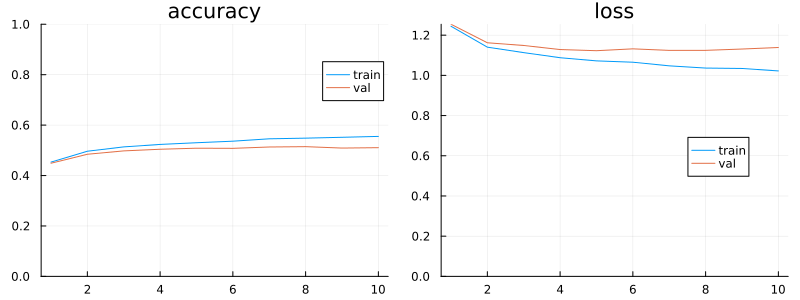

In [ ]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.8))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(directory, "history.png"))
p

## Test data

In [ ]:
logits = model(X_test)
accuracy(logits, y_test)

0.5086

In [ ]:
probs = softmax(logits, dims=1)
y_pred = Flux.onecold(probs);

In [ ]:
cm = confusion_matrix(vec(y_pred), Flux.onecold(y_test), 1:nlabels)

5×5 Matrix{Int64}:
 764  129   63   13   31
 373  265  262   64   36
 182  186  368  192   72
  40   61  226  388  285
  36   22   51  133  758

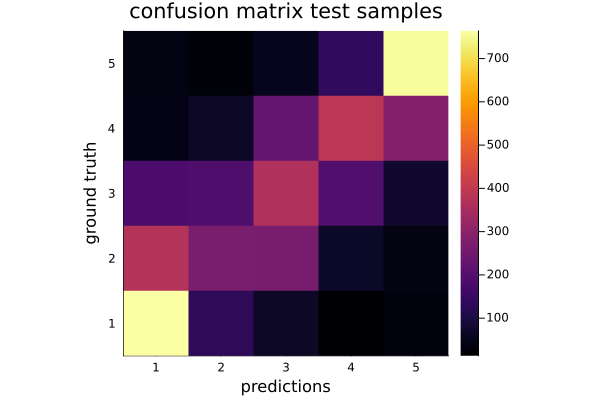

In [ ]:
p = heatmap(1:5, 1:5, cm, xlabel="predictions", ylabel="ground truth", xlims=(0.5, nlabels+0.5), aspectratio=1,
    title="confusion matrix test samples", xticks=(1:5)) #, ["negative", "mix", "positive"]))
savefig(p, joinpath(directory, "confusion_matrix.png"))
p

In [ ]:
classification_report(cm, 1:nlabels)

              precision  recall  f1-score  support
           1       0.55    0.76      0.64     1000
           2       0.40    0.27      0.32     1000
           3       0.38    0.37      0.37     1000
           4       0.49    0.39      0.43     1000
           5       0.64    0.76      0.69     1000

weighted avg       0.49    0.51      0.49     5000

### Examples

In [ ]:
println("star  y  ŷ   prob")
for star in nlabels:-1:1
    pos_max = argmax(probs[star, :])
    @printf("   %1d  %d  %d  %.4f  %s\n\n",
            star, labels_test[pos_max], y_pred[pos_max], probs[star, pos_max], documents_test[pos_max]
        )
end

star  y  ŷ   prob
   5  5  5  0.9962  All that I can say is that this product is amazing. This was given as a gift and the Birthday Girl has reported that she absolutely LOVE it. So does her son. Ha Ha. Great product and highly recommended.

   4  4  4  0.9076  Love the shirt. I wish the fabric of the shirt was softer.... a little rough. Overall good shirt

   3  3  3  0.6861  It was okay but the price is not worth it

   2  2  2  0.6606  Bought it for its features. While it worked, it was fine. Problems: was too inconsistent in detecting shots and tee boxes. So requires intervention almost every hole to ensure accuracy. Impossible to play well if one was to focus on the app. And after 11 months, almost 60% of the sensors are no longer working. Save your money and hassle.

   1  1  1  0.9891  Horrible product! Does not glide on smoothly and consistently. Will never purchase again. Trashed.



In [ ]:
nshow = 2

for label in 1:nlabels
    println("\ntrue label = $label")
    idxs = labels_test .== label
    idxs_label = (1:length(labels_test))[vec(idxs)]
    idxs_correct = idxs_label[y_pred[idxs] .== label]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    @printf("correct: %d / %d\n", length(idxs_correct), length(idxs_label))
    println(" idx  y  ŷ    prob  ")
    for idxs_subset in [idxs_correct, idxs_wrong]
        for idx in sample(idxs_subset, nshow, replace=false)
            println("-"^100)
            @printf("%4d  %d  %d  %.4f  %s\n",
                idx, labels_test[idx], y_pred[idx], probs[idx], documents_test[idx]
            )
        end
    end
    println("")
end


true label = 1
correct: 764 / 1000
 idx  y  ŷ    prob  
----------------------------------------------------------------------------------------------------
 206  1  1  0.5092  We had this in shower area where it only got moisture, no direct water. First the suction kept failing. Then the alarm mysteriously kept going off. Replaced batteries, No improvement. Couldn't turn it off or reset it. Garbage.
----------------------------------------------------------------------------------------------------
 664  1  1  0.0088  Almost all of the packages were hard to chew so I didn't bother opening the rest :(
----------------------------------------------------------------------------------------------------
 141  1  4  0.9737  Better off buying the kits
----------------------------------------------------------------------------------------------------
 761  1  2  0.3565  The speaker has a great sound and size is perfect for traveling. after around 6 months the speaker drops connection const

### Probabilities

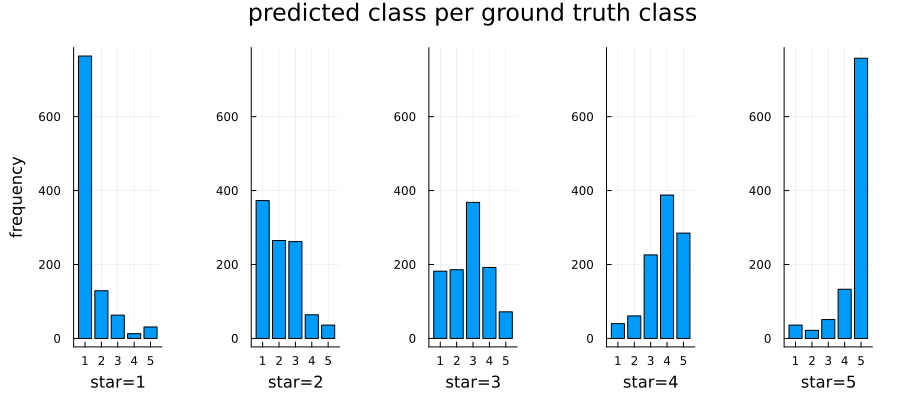

In [ ]:
canvases = []
label_names = 1:5
for gt_star in 1:5
    idxs = labels_test .== gt_star
    value_counts = [sum((y_pred[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="star=$gt_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="predicted class per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "prediction_star.png"))
p

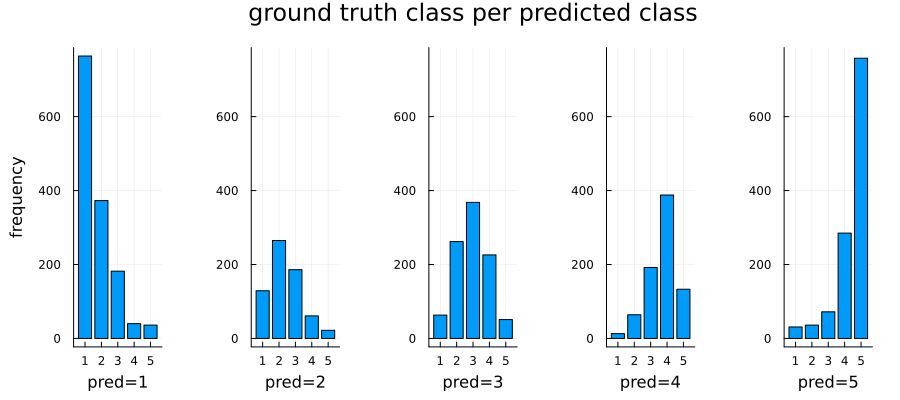

In [ ]:
canvases = []
label_names = 1:5
for pred_star in 1:5
    idxs = y_pred .== pred_star
    value_counts = [sum((labels_test[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="pred=$pred_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="ground truth class per predicted class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "star_prediction.png"))
p

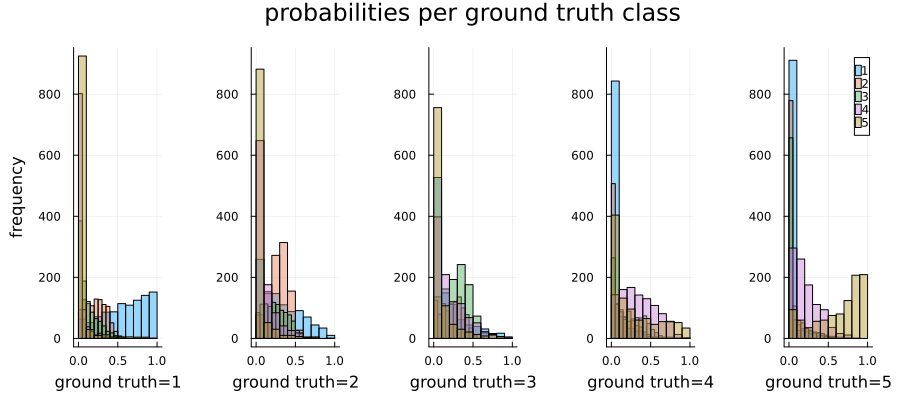

In [ ]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        histogram!(probs_star[pred_star, :], fillalpha=0.4, label=label_names[pred_star], nbins=12)
    end
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
plot!(canvases[5], legend=:best)
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilites_star.png"))
p

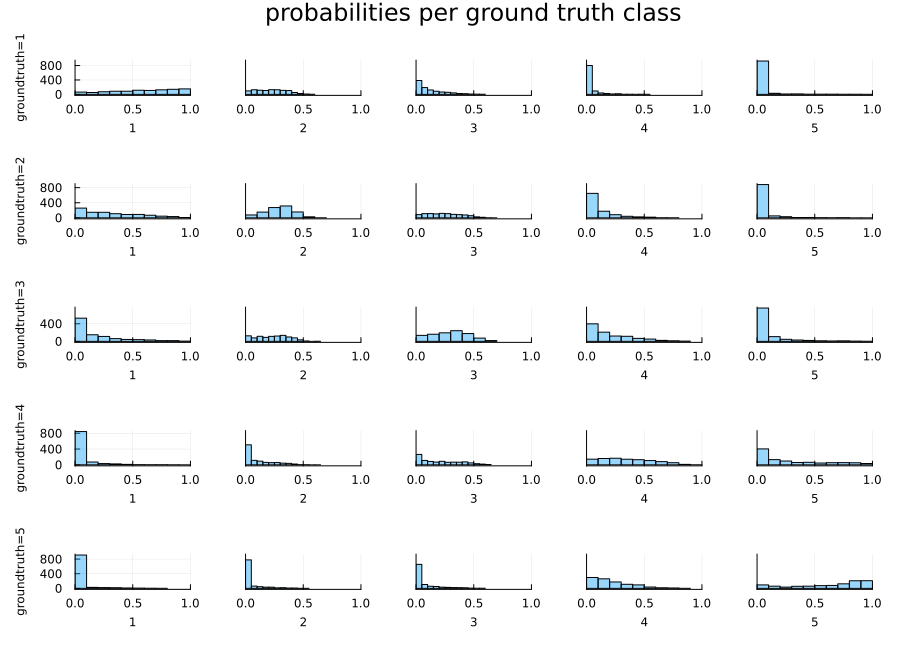

In [ ]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    #p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        p = histogram(probs_star[pred_star, :], fillalpha=0.4, label="", nbins=12,  
            xlims=[0, 1], xticks=([0.00, 0.50, 1.00]), yticks=([]), xlabel="$pred_star", xguidefontsize=8)
        push!(canvases, p)
    end
end

for groundtruth_star in 1:5
    plot!(canvases[1 + 5 * (groundtruth_star - 1)], ylabel="groundtruth=$groundtruth_star", yguidefontsize=8,
        yticks=([0, 400, 800])
    )
end
    
p =plot(canvases..., layout=(5, 5), link=:y, size=(900, 650), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilites_star_grid.png"))
p

### Single sample

In [ ]:
idx = 4600 

d = documents_test[idx]
println(labels_test[idx])
println(d)
tokens = preprocess(d, tokenizer, max_length=50)
println(join(tokens, "|"))
x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
I used for a party and was great !
⋅used|⋅for|⋅party|⋅and|⋅was|⋅great
89|7|805|4|14|29|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1


In [ ]:
model.embed(x)

32×50 Matrix{Float32}:
 -0.127633   -1.54647    2.16982    …  -0.138889   -0.138889   -0.138889
  0.125677    0.148507   0.916459      -0.326433   -0.326433   -0.326433
  0.403989   -1.0954     0.458737       0.174837    0.174837    0.174837
 -0.800601   -0.31646   -0.328081       0.019606    0.019606    0.019606
  0.704921   -0.695119  -0.669044      -0.196564   -0.196564   -0.196564
  0.835219   -0.628066   0.74248    …  -0.457125   -0.457125   -0.457125
 -0.306353   -0.307709   1.01175        0.0886018   0.0886018   0.0886018
 -0.902955    1.28467    0.235768      -0.255132   -0.255132   -0.255132
  0.832986    1.03      -0.806885       0.268721    0.268721    0.268721
 -0.226856    0.492244  -0.15959        0.487251    0.487251    0.487251
 -0.588045   -0.203734   0.0272763  …  -0.385282   -0.385282   -0.385282
  0.454865   -0.906452  -1.19605        0.146249    0.146249    0.146249
  2.64695     0.267169   0.117538       0.270824    0.270824    0.270824
  ⋮                        

In [ ]:
softmax(model(x))

5×1 Matrix{Float32}:
 0.0007240055
 0.0029478397
 0.009670615
 0.13774481
 0.8489127